In [2]:
import torch

def _standardize(kernel):
    """
    Makes sure that Var(W) = 1 and E[W] = 0
    """
    eps = 1e-6

    if len(kernel.shape) == 3:
        axis = [0, 1]  # last dimension is output dimension
    else:
        axis = 1

    var, mean = torch.var_mean(kernel, dim=axis, unbiased=True, keepdim=True)
    kernel = (kernel - mean) / (var + eps) ** 0.5
    return kernel


def he_orthogonal_init(tensor):
    """
    Generate a weight matrix with variance according to He initialization.
    Based on a random (semi-)orthogonal matrix neural networks
    are expected to learn better when features are decorrelated
    (stated by eg. "Reducing overfitting in deep networks by decorrelating representations",
    "Dropout: a simple way to prevent neural networks from overfitting",
    "Exact solutions to the nonlinear dynamics of learning in deep linear neural networks")
    """
    tensor = torch.nn.init.orthogonal_(tensor)

    if len(tensor.shape) == 3:
        fan_in = tensor.shape[:-1].numel()
    else:
        fan_in = tensor.shape[1]

    with torch.no_grad():
        tensor.data = _standardize(tensor.data)
        tensor.data *= (1 / fan_in) ** 0.5

    return tensor

class Dense(torch.nn.Module):
    """
    Combines dense layer and scaling for swish activation.

    Parameters
    ----------
        units: int
            Output embedding size.
        activation: str
            Name of the activation function to use.
        bias: bool
            True if use bias.
    """

    def __init__(
        self, in_features, out_features, bias=False, activation=None, name=None
    ):
        super().__init__()

        self.linear = torch.nn.Linear(in_features, out_features, bias=bias)
        self.reset_parameters()
        self.weight = self.linear.weight
        self.bias = self.linear.bias

        if isinstance(activation, str):
            activation = activation.lower()
        if activation in ["swish", "silu"]:
            self._activation = ScaledSiLU()
        elif activation is None:
            self._activation = torch.nn.Identity()
        else:
            raise NotImplementedError(
                "Activation function not implemented for GemNet (yet)."
            )

    def reset_parameters(self):
        he_orthogonal_init(self.linear.weight)
        if self.linear.bias is not None:
            self.linear.bias.data.fill_(0)

    def forward(self, x):
        x = self.linear(x)
        x = self._activation(x)
        return x


class ScaledSiLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.scale_factor = 1 / 0.6
        self._activation = torch.nn.SiLU()

    def forward(self, x):
        return self._activation(x) * self.scale_factor


class ResidualLayer(torch.nn.Module):
    """
    Residual block with output scaled by 1/sqrt(2).

    Parameters
    ----------
        units: int
            Output embedding size.
        nLayers: int
            Number of dense layers.
        activation: str
            Name of the activation function to use.
    """

    def __init__(self, units: int, nLayers: int = 2, activation=None, name=None):
        super().__init__()
        self.dense_mlp = torch.nn.Sequential(
            *[
                Dense(units, units, activation=activation, bias=False)
                for i in range(nLayers)
            ]
        )
        self.inv_sqrt_2 = 1 / (2.0 ** 0.5)

    def forward(self, inputs):
        x = self.dense_mlp(inputs)
        x = inputs + x
        x = x * self.inv_sqrt_2
        return x


In [3]:
import math
import torch
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GraphNorm, InstanceNorm

# from . import ResidualLayer, Dense, he_orthogonal_init

class CoorsNorm(nn.Module):
    def __init__(self, eps = 1e-8, scale_init = 1.):
        super().__init__()
        self.eps = eps
        scale = torch.zeros(1).fill_(scale_init)
        self.scale = nn.Parameter(scale)

    def forward(self, coors):
        norm = coors.norm(dim = -1, keepdim = True)
        normed_coors = coors / norm.clamp(min = self.eps)
        return normed_coors * self.scale

class Envelope(torch.nn.Module):
    """
    Envelope function that ensures a smooth cutoff.

    Parameters
    ----------
        p: int
            Exponent of the envelope function.
    """

    def __init__(self, p, name="envelope"):
        super().__init__()
        assert p > 0
        self.p = p
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, d_scaled):
        env_val = (
            1
            + self.a * d_scaled ** self.p
            + self.b * d_scaled ** (self.p + 1)
            + self.c * d_scaled ** (self.p + 2)
        )
        return torch.where(d_scaled < 1, env_val, torch.zeros_like(d_scaled))

def calculate_neighbor_angles(R_ac, R_ab):
        """Calculate angles between atoms c <- a -> b.

        Parameters
        ----------
            R_ac: Tensor, shape = (N,dim)
                Vector from atom a to c.
            R_ab: Tensor, shape = (N,dim)
                Vector from atom a to b.

        Returns
        -------
            angle_cab: Tensor, shape = (N, 2)
                [sin, cos] tensor between atoms c <- a -> b.
            angle_cab: Tensor, shape = (N, 1)
                theta belong to [0, pi] tensor between atoms c <- a -> b.
        """
        # Normalize vectors
        R_ac = R_ac / R_ac.norm(dim = -1, keepdim = True).clamp(min = 1e-8)
        R_ab = R_ab / R_ab.norm(dim = -1, keepdim = True).clamp(min = 1e-8)
        
        # cos(alpha) = (u * v) / (|u|*|v|)
        x = torch.sum(- R_ac * R_ab, dim=1, keepdim=True)  # shape = (N,1)
        
        # Check vector dimension to calculate sin(alpha)
        dim = R_ac.size(-1)
        assert(dim == 2 or dim == 3), "Only 2D and 3D angles are supported."
        if dim == 3:
            # 3D: sin(alpha) = |u × v| / (|u|*|v|) using cross product
            y = torch.cross(R_ac, R_ab).norm(dim=-1, keepdim=True)  # shape = (N,1)
        elif dim == 2:
            # 2D: sin(alpha) = (u.x*v.y - u.y*v.x) / (|u|*|v|)
            y = torch.abs(- R_ac[:, 0:1] * R_ab[:, 1:2] + R_ac[:, 1:2] * R_ab[:, 0:1])  # shape = (N,1)
        
        # Avoid numerical issues for gradient calculation
        y = torch.max(y, torch.tensor(1e-9, device=y.device))
        
        # Return [sin, cos] tensors
        # angle = torch.cat([y, x], dim=-1)  # shape = (N,2)
        angle = torch.atan2(y, x)
        # angle = x
        return angle

# Moved build_graph to module level for cleaner code structure
def build_graph(globs, coors, feats = None, edges = None, cutoff = math.inf, mask = None):
    """
    Build the graph structure from coordinates
    
    Args:
        globs: global attributes [b, g]
        coors: coordinate [b, n, d]
        feats: optional node features [b, n, f]
        edges: optional edge features [b, n, n, e]
        cutoff_distance: maximum distance for edge creation
        mask: optional mask [b, n, n]
        
    Returns:
        A dictionary containing all graph information including triplet data
    """
    b, n, d = coors.shape
    device = coors.device
    cutoff = (2 * math.pi) ** 2 if cutoff > (2 * math.pi) ** 2 else cutoff
    
    # Compute relative coordinates for all pairs
    rel_coors = - coors[:,:,None,:] + coors[:,None,:,:]  #  - [b, i, 1, d] + [b, 1, j, d] = [b, i, j, d] vec from i to j
    
    # Apply periodic boundary conditions
    rel_coors = rel_coors - 2 * math.pi * torch.round(rel_coors / (2 * math.pi))
    
    # Compute chord distance
    # rel_dist = (2 - 2 * torch.cos(rel_coors)).sum(dim=-1, keepdim=True)  # [b, n, n, 1]
    # Compute geodesic distance
    rel_dists = (rel_coors ** 2).sum(dim = -1, keepdim = True)  # [b, i, j, 1]
    
    with torch.no_grad():
        # Create distance-based cutoff mask
        dist_mask = (rel_dists <= cutoff) & (rel_dists > 0)  # [b, i, j, 1]
        deg = dist_mask.sum(dim=-2).flatten()  # [b*i] - number of valid edges per node
        deg_max = deg.max()  
        deg_cum = deg.cumsum(dim=0) - deg  # [b*i] - cumulative sum of degrees
        
        # Combine with provided mask if it exists
        if mask is not None:
            mask = mask.unsqueeze(-1) & dist_mask
        else:
            mask = dist_mask
        del dist_mask
            
        # Vectorized batch processing using PyG's batch support
        mask_flat = mask.flatten()  # [b*i*j]
        
        # Use meshgrid to efficiently create source and target indices
        row, col = torch.meshgrid(
            torch.arange(n, device=device),
            torch.arange(n, device=device),
            indexing='ij'
        )
        source_indices = row.flatten()  # [n*n]
        target_indices = col.flatten()  # [n*n]
        
        # Create batch offsets more efficiently
        batch_index = torch.arange(b, device=device).repeat_interleave(n*n)  # [b*n*n]
        batch_offsets = batch_index * n  # [b*n*n]
        
        # Apply offsets directly
        batch_source = source_indices.repeat(b) + batch_offsets  # [b*n*n]
        batch_target = target_indices.repeat(b) + batch_offsets  # [b*n*n]
        
        # Filter edges based on the mask
        valid_edges = mask_flat.bool()
        batch_index = batch_index[valid_edges]  # [num_edges]
        edge_index = torch.stack([
            batch_source[valid_edges],
            batch_target[valid_edges]
        ])  # [2, num_edges]
        # num_edges = edge_index.shape[1]  # Number of edges

        # pivot_node_index = edge_index[1]  # [num_edges] 
        # pivot_edge_num = deg[pivot_node_index]  # [num_edges]
        # num_triplets = pivot_edge_num.sum()  # Total number of triplets
        
        # # Create triplet indices
        # # For each edge j->k, find all edges i->j to create triplets (i->j, j->k)
        # # Repeat each edge index according to number of incoming edges to its target node
        # triplet_left_index = torch.repeat_interleave(torch.arange(num_edges, device=device), pivot_edge_num)  # [num_triplets]
        
        # # Calculate base offset for the starting index of each node's edge list
        # triplet_right_base = torch.repeat_interleave(deg_cum[pivot_node_index], pivot_edge_num)  # [num_triplets]
        
        # # Calculate relative index within each node's edge list
        # # Create sequential indices and reset counter at the start of each new node group
        # group_offsets = torch.repeat_interleave(torch.cumsum(pivot_edge_num, dim=0) - pivot_edge_num, pivot_edge_num)
        # triplet_right_kidx = torch.arange(num_triplets, device=device) - group_offsets  # [num_triplets]
        
        # # Combine base and relative indices to get final right edge indices
        # triplet_right_index = triplet_right_base + triplet_right_kidx  # [num_triplets]

        # # Filter out self-loops in triplets (where source of left edge equals target of right edge)
        # left_src_index = edge_index[0][triplet_left_index]  # Source nodes of left edges
        # right_tgt_index = edge_index[1][triplet_right_index]  # Target nodes of right edges
        # triplet_mask = (left_src_index != right_tgt_index)  # Exclude self-connections
        
        # # Final triplet indices: pairs of (left_edge_idx, right_edge_idx) forming valid triplets
        # triplet_index = torch.stack([
        #     triplet_left_index[triplet_mask],
        #     triplet_right_index[triplet_mask]
        # ])
        # num_triplets = triplet_index.shape[1]  # Number of triplets

    # Reshape coordinates and features based on the mask
    coors = coors.flatten(end_dim=-2)  # [b*n, d]
    if feats is not None:
        feats = feats.flatten(end_dim=-2)  # [b*n, f]

    # Reshape coordinates and distances based on the mask
    globs = globs[batch_index]  # [num_edges, g]
    rel_coors = rel_coors.reshape(-1, d)[valid_edges]  # [num_edges, d]
    rel_dists = rel_dists.reshape(-1, 1)[valid_edges]  # [num_edges, 1]
    if edges is not None:
        edges = edges.flatten(end_dim=-2)[valid_edges]  # [num_edges, e]
    
    # triplet_angles = calculate_neighbor_angles(
    #     rel_coors[triplet_index[0]],  # [num_triplets, d]
    #     rel_coors[triplet_index[1]]   # [num_triplets, d]
    # )  # [num_triplets, 2]

    # Return all the necessary components for graph operations
    return {
        'edge_index': edge_index,
        'globs': globs,
        'coors': coors,
        # 'triplet_index': triplet_index,
        # 'triplet_angles': triplet_angles,
        'feats': feats,
        'edges': edges,
        'rel_coors': rel_coors,
        'rel_dists': rel_dists,
        'b': b,
        'n': n,
        'd': d,
        # 'num_edges': num_edges,
        # 'num_triplets': num_triplets,
    }

# class Triplet_MessagePassing(MessagePassing):
#     def __init__(self, edge_input_dim: int, edge_out_dim: int, triplet_hidden_dim: int):
#         super().__init__(aggr='add')  # Use "add" aggregation

#         # triplet_input_dim = 2 * edge_input_dim + 2  # Include angles
#         # triplet_input_dim = edge_input_dim + 2  # Include angles
#         triplet_input_dim = edge_input_dim + 1  # Include angles

#         self.triplet_mlp = nn.Sequential(
#             Dense(triplet_input_dim, triplet_hidden_dim, activation='silu'),
#             nn.SiLU(),
#             ResidualLayer(triplet_hidden_dim, 2, activation='silu', name=None)
#         )

#         self.triplet_gate = nn.Sequential(
#             Dense(triplet_hidden_dim, 1),
#             nn.Sigmoid()
#         )
        
#         # Add bilinear layer to combine edge attributes with triplet messages
#         self.edge_update_bilinear = nn.Bilinear(edge_input_dim, triplet_hidden_dim, edge_out_dim, bias=False)
#         he_orthogonal_init(self.edge_update_bilinear.weight)


#     def forward(self, edge_message, triplet_index, triplet_angles, **kwargs):

#         # Run message passing - pass edge_attr to update() via the propagate call
#         edge_message_updated = self.propagate(
#             triplet_index,
#             edge_message=edge_message,
#             triplet_angles=triplet_angles,
#         )
        
#         # Return updated edge attributes
#         return edge_message_updated

#     def message(self, edge_message_i, edge_message_j, triplet_angles):

#         # triplet_attr = torch.cat([edge_message_i, edge_message_i, triplet_angles], dim=-1)
#         triplet_attr = torch.cat([edge_message_j, triplet_angles], dim=-1)  # [num_triplet, triplet_input_dim]

#         # Process edge attributes
#         m_ijk = self.triplet_mlp(triplet_attr)
#         m_ijk = m_ijk * self.triplet_gate(m_ijk)  # Apply gating
        
#         return m_ijk  # [num_triplet, triplet_hidden_dim]

#     def aggregate(self, inputs, index, ptr=None, dim_size=None):
#         # Use the default aggregation (sum)
#         return super().aggregate(inputs, index, ptr, dim_size)

#     def update(self, aggr_out, edge_message):
#         # Apply bilinear layer to combine original edge attributes with triplet messages
#         edge_message_updated = self.edge_update_bilinear(edge_message, aggr_out)
#         return edge_message_updated


# Based on E(n)-Equivariant Graph Neural Networks in torus space
class Coordinate_EGNN(MessagePassing):
    def __init__(self, glob_dim: int, feat_dim: int = 0, edge_dim: int = 0, hidden_dim: int = 64,
                 cutoff_distance: float = math.inf, 
                 norm_coors_scale_init: float = 1., 
                 envelope_exponent: int = 5):
        super().__init__(aggr="add")  # Use "add" aggregation
        
        self.cutoff_distance = (2 * math.pi) ** 2 if cutoff_distance > (2 * math.pi) ** 2 else cutoff_distance
        # Update edge_input_dim to include features from both source and target nodes
        edge_input_dim = glob_dim + 1 + (2 * feat_dim) + edge_dim
        
        self.edge_mlp = nn.Sequential(
            Dense(edge_input_dim, hidden_dim, activation='silu'),
            nn.SiLU(),
            ResidualLayer(hidden_dim, 2, activation='silu', name=None)
        )

        self.edge_gate = nn.Sequential(
            Dense(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.coors_norm = CoorsNorm(scale_init = norm_coors_scale_init)

        self.vec_mlp = nn.Sequential(
            ResidualLayer(hidden_dim, 2, activation='silu', name=None),
            nn.SiLU(),
            Dense(hidden_dim, 1),
        )

        self.envelope = Envelope(envelope_exponent)

        self.inv_sqrt_2 = 1 / (2.0 ** 0.5)

    def forward(self, graph_dict):
        '''
        globs: global attributes B*D'
        coors: coordinate (vec) attributes B*N*D
        '''

        # Extract parameters from the provided graph_dict
        b, n, d = graph_dict['b'], graph_dict['n'], graph_dict['d']
        edge_index = graph_dict['edge_index']
        globs = graph_dict['globs']
        coors = graph_dict['coors']
        feats = graph_dict['feats']
        edges = graph_dict['edges']
        rel_coors = graph_dict['rel_coors']
        rel_dists = graph_dict['rel_dists']
        # num_edges = graph_dict['num_edges']
        # num_triplets = graph_dict['num_triplets']
        
        # Create edge attributes - start with global attributes and distances
        edge_attr = torch.cat([globs, rel_dists], dim=-1)
        dists_env = self.envelope(rel_dists / self.cutoff_distance)
        
        # Conditionally add edge features if they exist
        if edges is not None:
            edge_attr = torch.cat([edge_attr, edges], dim=-1)
        
        # Run message passing
        coor_update = self.propagate(
            edge_index,
            size=(b * n, b * n),  # Size of the graph
            feats=feats,
            rel_coors=rel_coors,
            dists_env = dists_env,
            edge_attr=edge_attr
        )
        
        coors = coors + coor_update

        rel_coors = - coors[edge_index[0]] + coors[edge_index[1]]  # [num_edges, d] vec from i to j
        rel_coors = rel_coors - 2 * math.pi * torch.round(rel_coors / (2 * math.pi))

        rel_dists = (rel_coors ** 2).sum(dim = -1, keepdim = True)  # [num_edges, 1]

        graph_dict['coors'] = coors
        graph_dict['rel_coors'] = rel_coors
        graph_dict['rel_dists'] = rel_dists
        
        return coors
    
    def message(self, feats_i, feats_j, rel_coors, dists_env, edge_attr):
        if feats_i is not None and feats_j is not None:
            # Concatenate features from both source and target nodes
            edge_attr = torch.cat([edge_attr, feats_i, feats_j], dim=-1)

        # Process edge attributes
        m_ij = self.edge_mlp(edge_attr)
        m_ij = m_ij * self.edge_gate(m_ij)  # Apply gating
        
        # Compute vector messages
        mij_hat = self.vec_mlp(m_ij)  # [num_edges, 1]

        # Normalize relative coordinates
        rel_coors_norm = self.coors_norm(rel_coors)
        
        # Scale relative coordinates
        return mij_hat * rel_coors_norm * dists_env  # [num_edges, d]
    
    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        # Use the default aggregation (sum)
        return super().aggregate(inputs, index, ptr, dim_size)
    
    def update(self, aggr_out):
        # No additional processing needed after aggregation
        return aggr_out

# Based on E(n)-Equivariant Graph Neural Networks in torus space
# class Coordinate_Triplet_EGNN(MessagePassing):
#     def __init__(self, glob_dim: int, feat_dim: int = 0, edge_dim: int = 0, hidden_dim: int = 64,
#                  cutoff_distance: float = math.inf, 
#                  norm_coors_scale_init: float = 1., 
#                  envelope_exponent: int = 5):
#         super().__init__(aggr="add")  # Use "add" aggregation
        
#         self.cutoff_distance = (2 * math.pi) ** 2 if cutoff_distance > (2 * math.pi) ** 2 else cutoff_distance
#         # Update edge_input_dim to include features from both source and target nodes
#         edge_input_dim = glob_dim + 1 + (2 * feat_dim) + edge_dim
        
#         self.edge_mlp = nn.Sequential(
#             Dense(edge_input_dim, hidden_dim, activation='silu'),
#             nn.SiLU(),
#             ResidualLayer(hidden_dim, 2, activation='silu', name=None)
#         )

#         self.edge_gate = nn.Sequential(
#             Dense(hidden_dim, 1),
#             nn.Sigmoid()
#         )

#         self.triplet_interaction = Triplet_MessagePassing(
#             edge_input_dim=hidden_dim,
#             edge_out_dim=hidden_dim // 2,
#             triplet_hidden_dim=hidden_dim
#         )

#         self.coors_norm = CoorsNorm(scale_init = norm_coors_scale_init)

#         self.vec_alpha_mlp = nn.Sequential(
#             ResidualLayer(hidden_dim, 2, activation='silu', name=None),
#             nn.SiLU(),
#             Dense(hidden_dim, 1),
#         )

#         self.vec_beta_mlp = nn.Sequential(
#             ResidualLayer(hidden_dim // 2, 2, activation='silu', name=None),
#             nn.SiLU(),
#             Dense(hidden_dim // 2, 1),
#         )

#         self.envelope = Envelope(envelope_exponent)

#         self.inv_sqrt_2 = 1 / (2.0 ** 0.5)

#     def forward(self, graph_dict):
#         '''
#         globs: global attributes B*D'
#         coors: coordinate (vec) attributes B*N*D
#         '''

#         # Extract parameters from the provided graph_dict
#         b, n, d = graph_dict['b'], graph_dict['n'], graph_dict['d']
#         edge_index = graph_dict['edge_index']
#         triplet_index = graph_dict['triplet_index']
#         triplet_angles = graph_dict['triplet_angles']
#         globs = graph_dict['globs']
#         coors = graph_dict['coors']
#         feats = graph_dict['feats']
#         edges = graph_dict['edges']
#         rel_coors = graph_dict['rel_coors']
#         rel_dists = graph_dict['rel_dists']
#         num_edges = graph_dict['num_edges']
#         num_triplets = graph_dict['num_triplets']
        
#         # Create edge attributes - start with global attributes and distances
#         edge_attr = torch.cat([globs, rel_dists], dim=-1)
#         dists_env = self.envelope(rel_dists / self.cutoff_distance)
        
#         # Conditionally add edge features if they exist
#         if edges is not None:
#             edge_attr = torch.cat([edge_attr, edges], dim=-1)
        
#         # Run message passing
#         coor_update = self.propagate(
#             edge_index,
#             size=(b * n, b * n),  # Size of the graph
#             feats=feats,
#             rel_coors=rel_coors,
#             dists_env = dists_env,
#             edge_attr=edge_attr,
#             triplet_index = triplet_index,
#             triplet_angles = triplet_angles,
#         )
        
#         coors = coors + coor_update

#         rel_coors = - coors[edge_index[0]] + coors[edge_index[1]]  # [num_edges, d] vec from i to j
#         rel_coors = rel_coors - 2 * math.pi * torch.round(rel_coors / (2 * math.pi))

#         rel_dists = (rel_coors ** 2).sum(dim = -1, keepdim = True)  # [num_edges, 1]

#         graph_dict['coors'] = coors
#         graph_dict['rel_coors'] = rel_coors
#         graph_dict['rel_dists'] = rel_dists
        
#         return coors
    
#     def message(self, feats_i, feats_j, rel_coors, dists_env, edge_attr, triplet_index, triplet_angles):
#         if feats_i is not None and feats_j is not None:
#             # Concatenate features from both source and target nodes
#             edge_attr = torch.cat([edge_attr, feats_i, feats_j], dim=-1)

#         # Process edge attributes
#         m_ij = self.edge_mlp(edge_attr)
#         m_ij = m_ij * self.edge_gate(m_ij)  # Apply gating

#         m_ij_triplet = self.triplet_interaction(m_ij, triplet_index, triplet_angles)
        
#         # Compute vector messages
#         mij_alpha = self.vec_alpha_mlp(m_ij)  # [num_edges, 1]
#         mij_beta = self.vec_beta_mlp(m_ij_triplet)  # [num_edges, 1]

#         # Normalize relative coordinates
#         rel_coors_norm = self.coors_norm(rel_coors)
        
#         # Scale relative coordinates
#         return (mij_alpha + mij_beta) * rel_coors_norm * dists_env  # [num_edges, d]
    
#     def aggregate(self, inputs, index, ptr=None, dim_size=None):
#         # Use the default aggregation (sum)
#         return super().aggregate(inputs, index, ptr, dim_size)
    
#     def update(self, aggr_out):
#         # No additional processing needed after aggregation
#         return aggr_out

# Multi-layer version of CoordinateEGNN with optimized graph construction
class PINN2D(nn.Module):
    def __init__(self, glob_dim: int, feat_dim: int = 0, edge_dim: int = 0, hidden_dim: int = 64, 
                 norm_coors_scale_init: float = 1.0, cutoff_distance: float = math.inf, num_layers: int = 1):
        super().__init__()
        self.cutoff_distance = cutoff_distance
        
        # Create a ModuleList to hold multiple EGNN layers
        self.layers = nn.ModuleList([
            Coordinate_EGNN(
            # Coordinate_Triplet_EGNN(
                glob_dim=glob_dim, 
                feat_dim=feat_dim, 
                edge_dim=edge_dim, 
                hidden_dim=hidden_dim, 
                norm_coors_scale_init=norm_coors_scale_init, 
                cutoff_distance=cutoff_distance,
            )
            for _ in range(num_layers)
        ])
        
    def forward(self, globs, coors, shape, feats=None, edges=None, mask=None):
        """
        Apply multiple EGNN layers sequentially with a single graph construction
        
        Args:
            globs: global attributes (batch_size, D')
            coors: flattened coordinate attributes (total_size, d)
            shape: tuple of (batch_size, n_particles, dim) to reshape coordinates
            feats: node features (optional)
            edges: edge features (optional)
            mask: attention mask (optional)
        """
        # Extract shape information
        b, n, d = shape
        
        # Reshape flattened coordinates to (b, n, d) for graph building
        coors = coors.reshape(b, n, d)
        feats = feats.reshape(b, n, -1) if feats is not None else None
        edges = edges.reshape(b, n, n, -1) if edges is not None else None

        # Build graph structure once using the standalone function
        graph_dict = build_graph(globs, coors, feats, edges, self.cutoff_distance, mask)

        coors_residual = graph_dict['coors']
        
        # Apply each layer sequentially using the same graph structure
        for layer in self.layers:
            coors = layer(graph_dict)
        
        graph_dict['coors'] -= coors_residual
        
        return graph_dict['coors'].reshape(b, n*d)

# class Coordinate_Volume_Network(nn.Module):
#     def __init__(self, glob_dim: int = 2, feat_dim: int = 0, edge_dim: int = 0, hidden_dim: int = 64, 
#                  dropout: float = 0.1, norm_coors: bool = True, norm_coors_scale_init: float = 1.0, 
#                  cutoff_distance: float = math.inf, num_layers: int = 1, use_norm: str = None):
#         super().__init__()
        
#         self.cutoff_distance = cutoff_distance
        
#         # Create a ModuleList to hold multiple EGNN layers
#         self.coordinate_layers = nn.ModuleList([
#             Coordinate_EGNN(
#                 glob_dim=glob_dim, 
#                 feat_dim=feat_dim, 
#                 edge_dim=edge_dim, 
#                 hidden_dim=hidden_dim, 
#                 dropout=dropout, 
#                 norm_coors=norm_coors, 
#                 norm_coors_scale_init=norm_coors_scale_init, 
#                 cutoff_distance=cutoff_distance,
#                 use_norm=use_norm
#             )
#             for _ in range(num_layers)
#         ])

#         self.volume_layers = nn.Sequential(
#             Dense(
#                 in_features=glob_dim,
#                 out_features=hidden_dim,
#                 activation='silu'
#             ),
#             *[ResidualLayer(hidden_dim, 2, activation='silu', name=None)
#             for _ in range(num_layers)],
#             Dense(
#                 in_features=hidden_dim,
#                 out_features=1,
#                 activation=None
#             )
#         )
        
#     def forward(self, t, coors_vol, shape, feats=None, edges=None, mask=None):
#         """
#         Apply multiple EGNN layers sequentially with a single graph construction
        
#         Args:
#             globs: global attributes (batch_size, D')
#             coors: flattened coordinate attributes (total_size, d)
#             shape: tuple of (batch_size, n_particles, dim) to reshape coordinates
#             feats: node features (optional)
#             edges: edge features (optional)
#             mask: attention mask (optional)
#         """
#         # Extract shape information
#         b, n, d = shape
        
#         coors = coors_vol[:, :-1]
#         vol = coors_vol[:, -1:]
#         globs = torch.cat([t, vol], dim = -1)

#         # Calculate volume
#         vol = self.volume_layers(globs)

#         # Calculate coordinates
#         # Reshape flattened coordinates to (b, n, d) for graph building
#         coors = coors.reshape(b, n, d)

#         coors_residual = coors
        
#         # Apply each layer sequentially using the same graph structure
#         for layer in self.coordinate_layers:
#             # Build graph structure once using the standalone function
#             graph_dict = build_graph(coors, self.cutoff_distance, mask)
#             coors = layer(graph_dict, globs, coors, feats, edges)
        
#         coors -= coors_residual

#         # Flatten output coordinates back to the input format        
#         coors_vol = torch.cat([coors.flatten(start_dim=1), vol], dim = -1)

#         return coors_vol

In [4]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.init as init
import time
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [16]:
!nvidia-smi

1024.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Tue May 20 09:42:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:03:00.0 Off |                    0 |
|  0%   44C    P0             80W /  300W |   45503MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class Time_residual(nn.Module):
    def __init__(self, num_hidden_layers=2, num_neurons_per_layer=128):
        super().__init__()
        
        # Input layer: 1D input (time)
        self.input_layer = nn.Linear(1, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: 1D output (time residual)
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        nn.init.xavier_normal_(self.input_layer.weight.data)
        nn.init.zeros_(self.input_layer.bias.data)
        
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)
            
        nn.init.xavier_normal_(self.output_layer.weight.data)
        nn.init.zeros_(self.output_layer.bias.data)

    def forward(self, t):
        """
        Forward pass through the network.
        
        Args:
            t (torch.Tensor): Time input of shape [batch_size, 1]
            
        Returns:
            torch.Tensor: Time residual output c_t of shape [batch_size, 1]
        """
        # Pass through network with residual connections
        outputs = self.activation(self.input_layer(t))
        
        for layer in self.hidden_layers:
            layer_output = self.activation(layer(outputs))
            outputs = layer_output + outputs  # Residual connection
        
        # Final output layer
        c_t = self.output_layer(outputs)
        
        return c_t

In [5]:
def lennard_jones_energy_full(x, n_particles, n_dims, box_length=2*torch.pi, eps=1.0, rm=1.0, r_switch=0.95, r_cutoff=2.5, remove_diagonal=True):
    """
    Compute Lennard-Jones energy using linear approximation for r < r_cut.
    Args:
        x: Tensor of shape (B, N * D), flattened particle coordinates
        n_particles: Number of particles N
        n_dims: Number of spatial dimensions D
        box_length: Periodic box size
        eps, rm: LJ parameters
        r_cut: linear cutoff distance
        remove_diagonal: whether to exclude self-interactions
        
    Returns:
        lj_energy: Tensor of shape (B, 1)
    """

    # 1. Reshape x to (B, N, D)
    x = x.view(-1, n_particles, n_dims)

    # 2. Apply PBC to compute pairwise displacements: shape (B, N, N, D)
    delta = x.unsqueeze(2) - x.unsqueeze(1)  # [B, N, N, D]
    delta = delta - box_length * torch.round(delta / box_length)

    # 3. Optionally remove diagonal entries
    if remove_diagonal:
        B, N, _, D = delta.shape
        mask = ~torch.eye(N, dtype=torch.bool, device=x.device)  # [N, N]
        mask = mask.unsqueeze(0).expand(B, N, N)                 # [B, N, N]
        delta = delta[mask].view(B, N, N - 1, D)

    # 4. Compute distances r = ||delta||: shape (B, N, N-1)
    r = delta.pow(2).sum(dim=-1).sqrt()  # [B, N, N-1]

    # 5. Compute linear approximation: V = a * r + b where r < r_cut
    a = -10.0
    lj_at_cut = 4.0 * eps * ((rm / r_switch)**12 - (rm / r_switch)**6)
    b = lj_at_cut - a * r_switch
    V = a * r + b

    # 6. Apply full LJ where r >= r_cut
    mask = (r >= r_switch)
    if mask.any():
        r_big = r[mask]
        V[mask] = 4.0 * eps * ((rm / r_big)**12 - (rm / r_big)**6)
    
    V[r > r_cutoff] = 0.0

    # 7. Sum over all pairwise terms, divide by 2 to avoid double counting
    lj_energy = V.sum(dim=(-2, -1)) / 2  # shape (B,)
    
    return lj_energy[:, None]  # shape (B, 1)

In [8]:
def vector_distance(samples,Velocity,f_t):
    # Samples is a tensor of shape (B, N*D）
    # Velocity_field is a tensor of shape (B, N*D)
    # Internal_energy_ is a tensor of shape (B,1)
    # Expected result is a tensor of shape (B,1)
    
    gradient = torch.autograd.grad(f_t, samples, grad_outputs=torch.ones_like(f_t), create_graph=True)[0]
    # Detect when gradient exists Nan, output samples and inter_energy

    if torch.isnan(gradient).any():
        nan_mask = torch.isnan(gradient).any(dim=1)
        print("NaN detected in gradient!")
        print("Problematic samples:\n", samples[nan_mask])
        print("Corresponding internal energy:\n", f_t[nan_mask])
        raise ValueError("NaN detected in gradient computation.")

    # Compute the distance
    result = torch.sum(gradient * Velocity,dim = 1)
    
    assert not torch.isnan(result).any(), "Result is NaN"
    result = result.unsqueeze(dim = 1)
    return result

In [9]:
def compute_divergence(Velocity, t, x, n_particles, n_dimension, n_pde_points):
    """
    model: the neural network representing the vector field
    t: torch tensor of shape [B, 1]
    x: torch tensor of shape [B, D]
    """
    x.requires_grad_(True)
    v = Velocity(t, x, (n_pde_points, n_particles, n_dimension))  # [B, D]
    
    divergence = torch.zeros(x.shape[0], device=x.device)
    for i in range(v.shape[1]):
        grad_v_i = torch.autograd.grad(
            outputs=v[:, i],
            inputs=x,
            grad_outputs=torch.ones_like(v[:, i]),
            create_graph=True,
            retain_graph=True
        )[0][:, i]  # 只取 ∂v_i/∂x_i
        divergence += grad_v_i

    return divergence.view(-1,1)  # shape [B]

In [10]:
def pde_formula(x, t_value, Velocity_model, Normalizing_model, n_particles, n_dimension, n_pde_points):
    '''
    t_value: torch tensor of shape [B, 1]
    x: torch tensor of shape [B, N*D]
    '''
    # First term is energy
    U = lennard_jones_energy_full(x, n_particles, n_dimension)
    f_t = t_value * U
    # check if U is NaN
    assert torch.isnan(f_t).sum() == 0, "Energy is NaN"

    shape = (n_pde_points, n_particles, n_dimension)
    velocity_field = Velocity_model(t_value, x, shape)
    assert torch.isnan(velocity_field).sum() == 0, "Velocity field is NaN"
    
    term2 = vector_distance(x, velocity_field, f_t)
    assert torch.isnan(term2).sum() == 0, "Term2 is NaN"
        
    trace_average = compute_divergence(Velocity_model, t_value, x, n_particles, n_dimension, n_pde_points)
    assert torch.isnan(trace_average).sum() == 0, "Trace average is NaN"

    C_t = Normalizing_model(t_value)
    assert torch.isnan(C_t).sum() == 0, "C_t is NaN"

    return torch.abs(U + term2 - trace_average +C_t) + (U + term2 - trace_average +C_t)**2


In [11]:
# Loss function for 2D PINN with time range [0.1, 1] and vector output correction
def compute_loss(Velocity, Time_residual, n_particles, n_dimension, device="cuda", bound = 2*torch.pi):
    # Sample collocation points for PDE residual
    n_pde_points = 36  # Number of points inside domain
    samples = torch.rand(n_pde_points, n_particles*n_dimension, device=device,requires_grad=True) * bound - bound/2  # Range [-10, 10]
    t_value = 1.0 - torch.rand(n_pde_points, 1, device=device)
    pde_loss_t = pde_formula(samples, t_value, Velocity, Time_residual, n_particles, n_dimension, n_pde_points)
    pde_loss = torch.mean(pde_loss_t)

   
    # Initial condition points at t=0.1 (smallest valid t)
    n_ic_points = 18
    shape = (n_ic_points, n_particles, n_dimension)
    samples_prior_ic = torch.rand(n_ic_points, n_particles*n_dimension, device=device)* bound - bound/2    # Range [-10, 10]
    t_ic = torch.zeros(n_ic_points, 1, device=device)      
    u_ic_pred = Velocity(t_ic, samples_prior_ic, shape)
    u_ic_true = 1
    ic_loss = torch.sum((u_ic_pred - u_ic_true)**2,dim = 1)
    ic_loss = torch.mean(ic_loss)
    
    # Boundary conditions
    n_bc_points = 18
    shape = (n_bc_points, n_particles, n_dimension)
    # Left boundary (x = -10)
    samples_prior_left = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2 
    samples_prior_left[:, 0] = -torch.pi   # Range [-10, 10]
    t_bc_left = torch.rand(n_bc_points, 1, device=device)  
    u_bc_left_pred = Velocity(t_bc_left, samples_prior_left, shape)
    u_bc_left_true = torch.zeros_like(u_bc_left_pred, device=device)
    bc_loss_left = torch.sum((u_bc_left_pred - u_bc_left_true)**2,dim = 1)
    bc_loss_left = torch.mean(bc_loss_left)
    
    # Right boundary (x = 10)
    samples_prior_right = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2 
    samples_prior_right[:, 0] = torch.pi
    t_bc_right = torch.rand(n_bc_points, 1, device=device)   
    u_bc_right_pred = Velocity(t_bc_right, samples_prior_right, shape)
    u_bc_right_true = torch.zeros_like(u_bc_right_pred, device=device)
    bc_loss_right = torch.sum((u_bc_right_pred - u_bc_right_true)**2,dim = 1)
    bc_loss_right = torch.mean(bc_loss_right)
    
    # Bottom boundary (y = -10)
    samples_prior_bottom = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2
    samples_prior_bottom[:, 1] = -torch.pi  
    t_bc_bottom = torch.rand(n_bc_points, 1, device=device) 
    u_bc_bottom_pred = Velocity(t_bc_bottom, samples_prior_bottom, shape)
    u_bc_bottom_true = torch.zeros_like(u_bc_bottom_pred, device=device)
    bc_loss_bottom = torch.sum((u_bc_bottom_pred - u_bc_bottom_true)**2,dim = 1)
    bc_loss_bottom = torch.mean(bc_loss_bottom)
    
    # Top boundary (y = 10)
    samples_prior_top = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2
    samples_prior_top[:, 1] = torch.pi
    t_bc_top = torch.rand(n_bc_points, 1, device=device) 
    u_bc_top_pred = Velocity(t_bc_top, samples_prior_top, shape)
    u_bc_top_true = torch.zeros_like(u_bc_top_pred, device=device)
    bc_loss_top = torch.sum((u_bc_top_pred - u_bc_top_true)**2,dim = 1)
    bc_loss_top = torch.mean(bc_loss_top)

    # Total boundary loss
    bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top
    
    # Total loss
    total_loss = pde_loss + ic_loss + bc_loss 
    
    return total_loss, pde_loss, ic_loss, bc_loss

In [12]:
# Training function
def train(n_particles, n_dimension, Velocity, Time_residual, optimizer,scheduler, device="cuda",n_epochs=10000, print_every=1000):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        total_loss,pde_loss,ic_loss,bc_loss = compute_loss(Velocity, Time_residual, n_particles, n_dimension,device)
        total_loss.backward()
        
        optimizer.step()
        # scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{n_epochs} - Time: {elapsed:.2f}s - "
                  f"Loss: {total_loss.item():.6f}, PDE: {pde_loss.item():.6f}, "
                  f"IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")
    
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return Velocity, Time_residual, loss_history

In [14]:
n_particles = 3
n_dimension = 2

n_layers_V = 2
n_neurons_V = 128

n_layers_T = 1
n_neurons_T = 128

device = torch.device("cuda")
Velocity = PINN2D(
    glob_dim=1,         # 每个边的全局特征维度（例如温度、系统能量等）
    feat_dim=0,         # 每个粒子的特征维度
    edge_dim=0,         # 每对粒子的边特征维度（可选）
    hidden_dim=128,      # 每层的隐藏层维度
    norm_coors_scale_init=1.0,  # 坐标归一化初始缩放因子
    cutoff_distance=torch.pi,  # 截断距离
    num_layers=1        # 使用3层Coordinate_EGNN网络
).to(device)
Time = Time_residual(n_layers_T, n_neurons_T).to(device)

optimizer = torch.optim.Adam(list(Velocity.parameters()) + list(Time.parameters()), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)

# from torch.optim.lr_scheduler import CyclicLR

# scheduler = CyclicLR(
#     optimizer,
#     base_lr=1e-5,              # 最低 lr
#     max_lr=1e-2,               # 初始峰值
#     step_size_up=1000,         # 上升到峰值需要 2000 步
#     step_size_down=1000,       # 再下降回最低也 2000 步
#     mode='triangular',        # 每个周期峰值自动乘 1/2
#     cycle_momentum=False
# )


Velocity, Time, loss_history = train(
    n_particles=n_particles,
    n_dimension=n_dimension,
    Velocity=Velocity,
    Time_residual=Time,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    n_epochs=10000,
    print_every=200
)

torch.save(Velocity.state_dict(), "Exp1_velocity_model.pth")
torch.save(Time.state_dict(), "Exp1_time_model.pth")

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


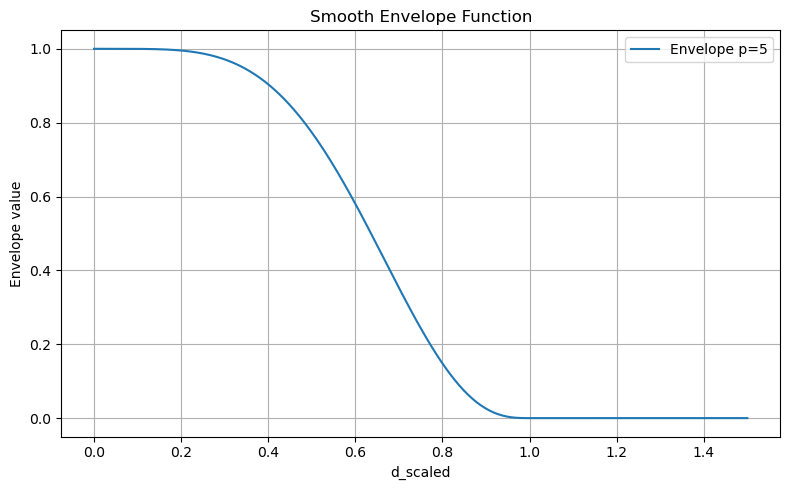

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def envelope_function(d_scaled, p):
    a = -(p + 1) * (p + 2) / 2
    b = p * (p + 2)
    c = -p * (p + 1) / 2

    env_val = (
        1
        + a * d_scaled ** p
        + b * d_scaled ** (p + 1)
        + c * d_scaled ** (p + 2)
    )
    env_val[d_scaled >= 1] = 0.0
    return env_val

# 参数设置
p = 5
x = np.linspace(0, 1.5, 300)
y = envelope_function(x, p)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'Envelope p={p}')
plt.xlabel("d_scaled")
plt.ylabel("Envelope value")
plt.title("Smooth Envelope Function")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
device = torch.device("cpu")
Velocity = PINN2D(
    glob_dim=1,         # 每个边的全局特征维度（例如温度、系统能量等）
    feat_dim=0,         # 每个粒子的特征维度
    edge_dim=0,         # 每对粒子的边特征维度（可选）
    hidden_dim=128,      # 每层的隐藏层维度
    norm_coors_scale_init=1.0,  # 坐标归一化初始缩放因子
    cutoff_distance=2*torch.pi,  # 截断距离
    num_layers=1        # 使用3层Coordinate_EGNN网络
).to(device)

In [32]:
n_pde_points = 2  # Number of points inside domain
bound = torch.pi * 2
n_particles = 3
n_dimension = 2
samples = torch.rand(n_pde_points, n_particles*n_dimension, device=device,requires_grad=True) * bound - bound/2  # Range [-10, 10]
t_value = torch.ones(n_pde_points, 1, device=device)
shape = (n_pde_points, n_particles, n_dimension)
# 计算速度场
velocity_field = Velocity(t_value, samples, shape)
velocity_field


tensor([[ 1.1802e-04,  1.6451e-05, -1.1802e-04, -1.6451e-05,  0.0000e+00,
          0.0000e+00],
        [-1.3113e-05,  6.3181e-05,  0.0000e+00,  0.0000e+00,  1.3113e-05,
         -6.3181e-05]], grad_fn=<ViewBackward0>)

# Translation equivariance

$y+g = \Phi(x+g)$

In [33]:
n_pde_points = 2  # Number of points inside domain
bound = torch.pi*2 
n_particles = 2
n_dimension = 2

samples = torch.rand(n_pde_points, n_particles*n_dimension, device=device,requires_grad=True) * bound - bound/2
t_value = torch.ones(n_pde_points, 1, device=device)
shape = (n_pde_points, n_particles, n_dimension)
trans_vec = (torch.ones(1, n_dimension, device=device) * 2 - 1) * 1
samples = samples.reshape(n_pde_points, n_particles, n_dimension)
samples_trans = (samples + trans_vec) - bound * torch.round((samples + trans_vec) / (bound))
print("original:", samples) 
print("translation:", trans_vec)
print("after:", samples_trans)

original: tensor([[[ 2.2567,  3.0465],
         [ 1.5930, -0.8757]],

        [[ 0.4660, -2.1148],
         [-1.7998, -1.6567]]], grad_fn=<ViewBackward0>)
translation: tensor([[1., 1.]])
after: tensor([[[-3.0265, -2.2367],
         [ 2.5930,  0.1243]],

        [[ 1.4660, -1.1148],
         [-0.7998, -0.6567]]], grad_fn=<SubBackward0>)


In [34]:
velocity_original = Velocity(t_value, samples.reshape(n_pde_points, -1), shape)
velocity_after = Velocity(t_value, samples_trans.reshape(n_pde_points, -1), shape)

print("samples_original:", samples.reshape(n_pde_points, -1))
print("samples_after", samples_trans.reshape(n_pde_points, -1))
print("velocity_original:", velocity_original)
print("velocity_after:", velocity_after)

samples_original: tensor([[ 2.2567,  3.0465,  1.5930, -0.8757],
        [ 0.4660, -2.1148, -1.7998, -1.6567]], grad_fn=<ViewBackward0>)
samples_after tensor([[-3.0265, -2.2367,  2.5930,  0.1243],
        [ 1.4660, -1.1148, -0.7998, -0.6567]], grad_fn=<ViewBackward0>)
velocity_original: tensor([[ 0.0003, -0.0010, -0.0003,  0.0010],
        [ 0.0195, -0.0039, -0.0195,  0.0039]], grad_fn=<ViewBackward0>)
velocity_after: tensor([[ 0.0003, -0.0010, -0.0003,  0.0010],
        [ 0.0195, -0.0039, -0.0195,  0.0039]], grad_fn=<ViewBackward0>)
